In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.autonotebook import tqdm
import numpy as np
import pandas as pd
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,Activation
from keras.layers import Lambda,Input,GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [3]:
#reading labels csv file
labels = pd.read_csv('../input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,9eb927fcd2caba4b3d0dfc193a1dfbb4,scottish_deerhound
freq,1,126


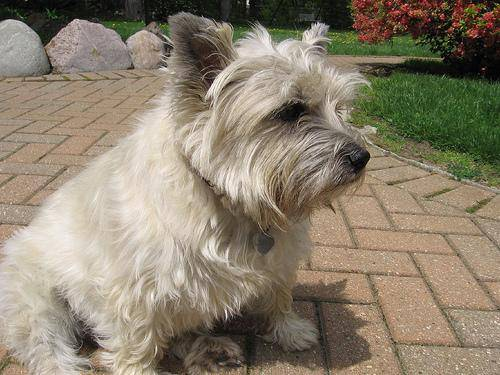

In [5]:
#check one image
from IPython.display import display,Image
Image("../input/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg")

In [6]:
import os
if len(os.listdir('../input/dog-breed-identification/train')) == len(labels['id']):
  print("Number of file matches of actual images!")
else:
  print("Number of file does not matches number of actual images!!")

Number of file matches of actual images!


In [7]:
#create list of alphabetical sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))

#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

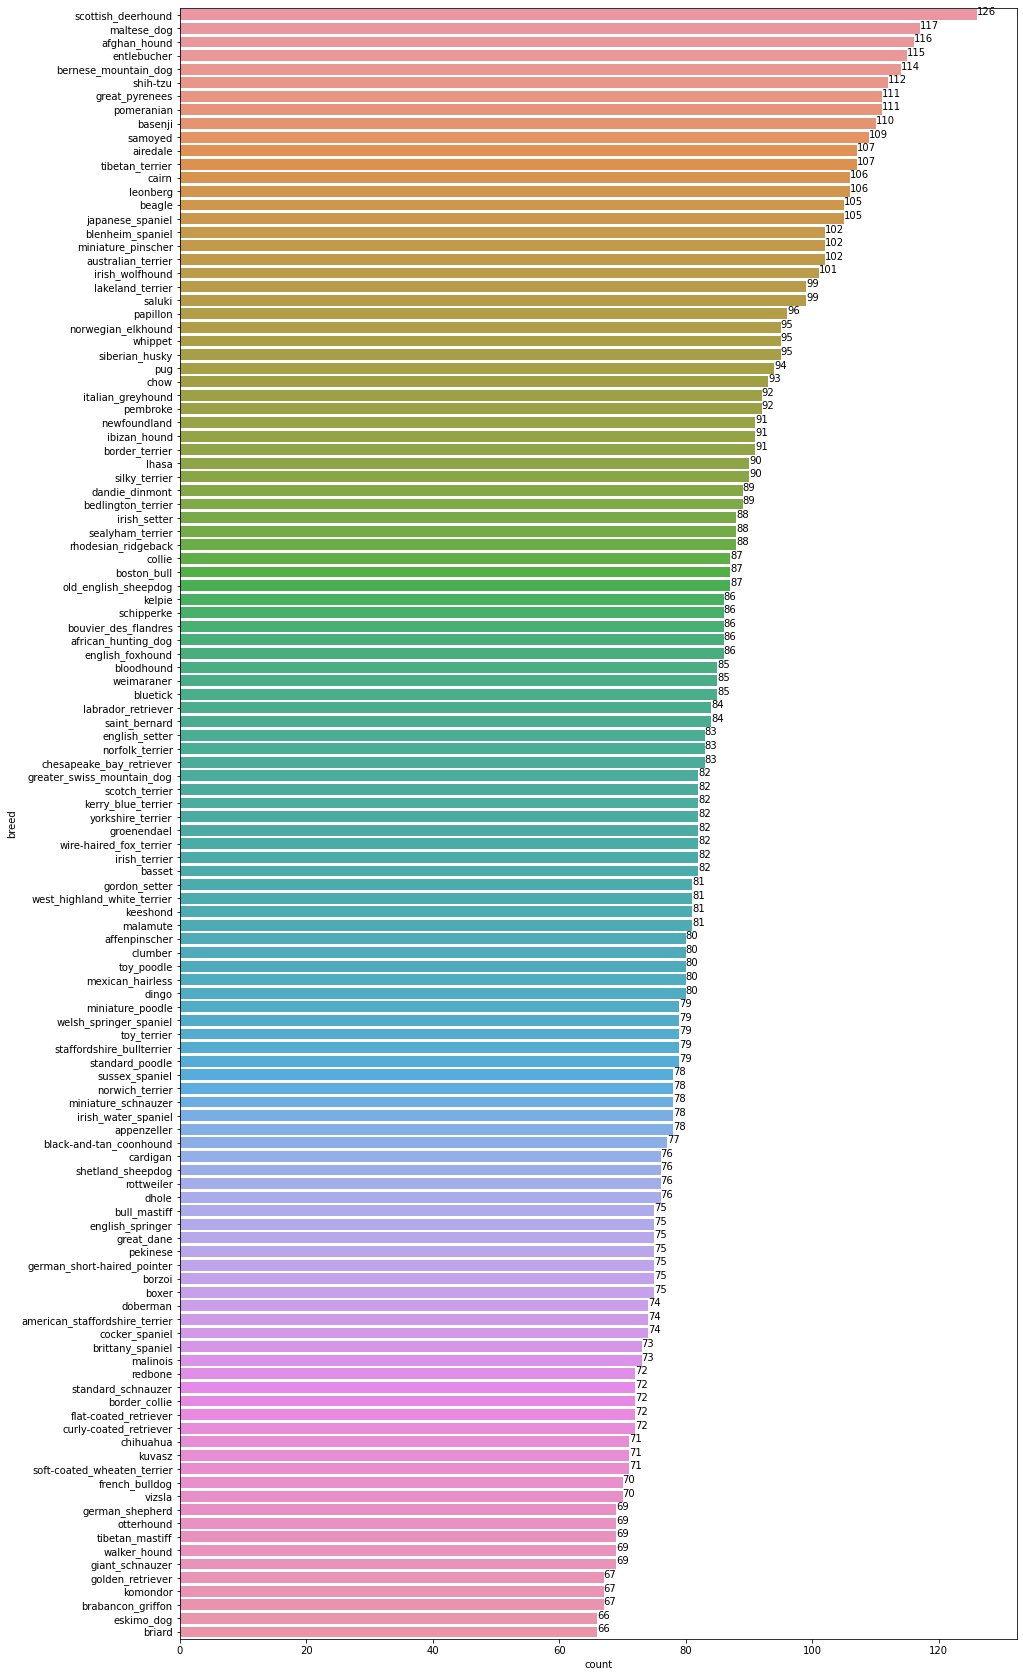

In [8]:
def barw(ax):
    
    for p in ax.patches:
        val = p.get_width()
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(val,2),(x,y))
        
plt.figure(figsize = (15,30))
ax0 = sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

In [9]:
input_shape = (331,331,3)

def images_to_array(directory, label_dataframe,target_size = input_shape):
  image_labels = label_dataframe['breed']
  images = np.zeros([len(label_dataframe),target_size[0], target_size[1], target_size[2]], dtype=np.uint8)
  y = np.zeros([len(label_dataframe),1],dtype=np.uint8)

  for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
    img_dir = os.path.join(directory, image_name +'.jpg')
    img = load_img(img_dir, target_size= target_size)
    images[ix] = img
    del img
    dog_breed = image_labels[ix]
    y[ix] = class_to_num[dog_breed]
  y = to_categorical(y)
  return images,y

In [10]:
import time
t = time.time()
x,y = images_to_array('../input/dog-breed-identification/train',labels[:])
print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 117.45758724212646


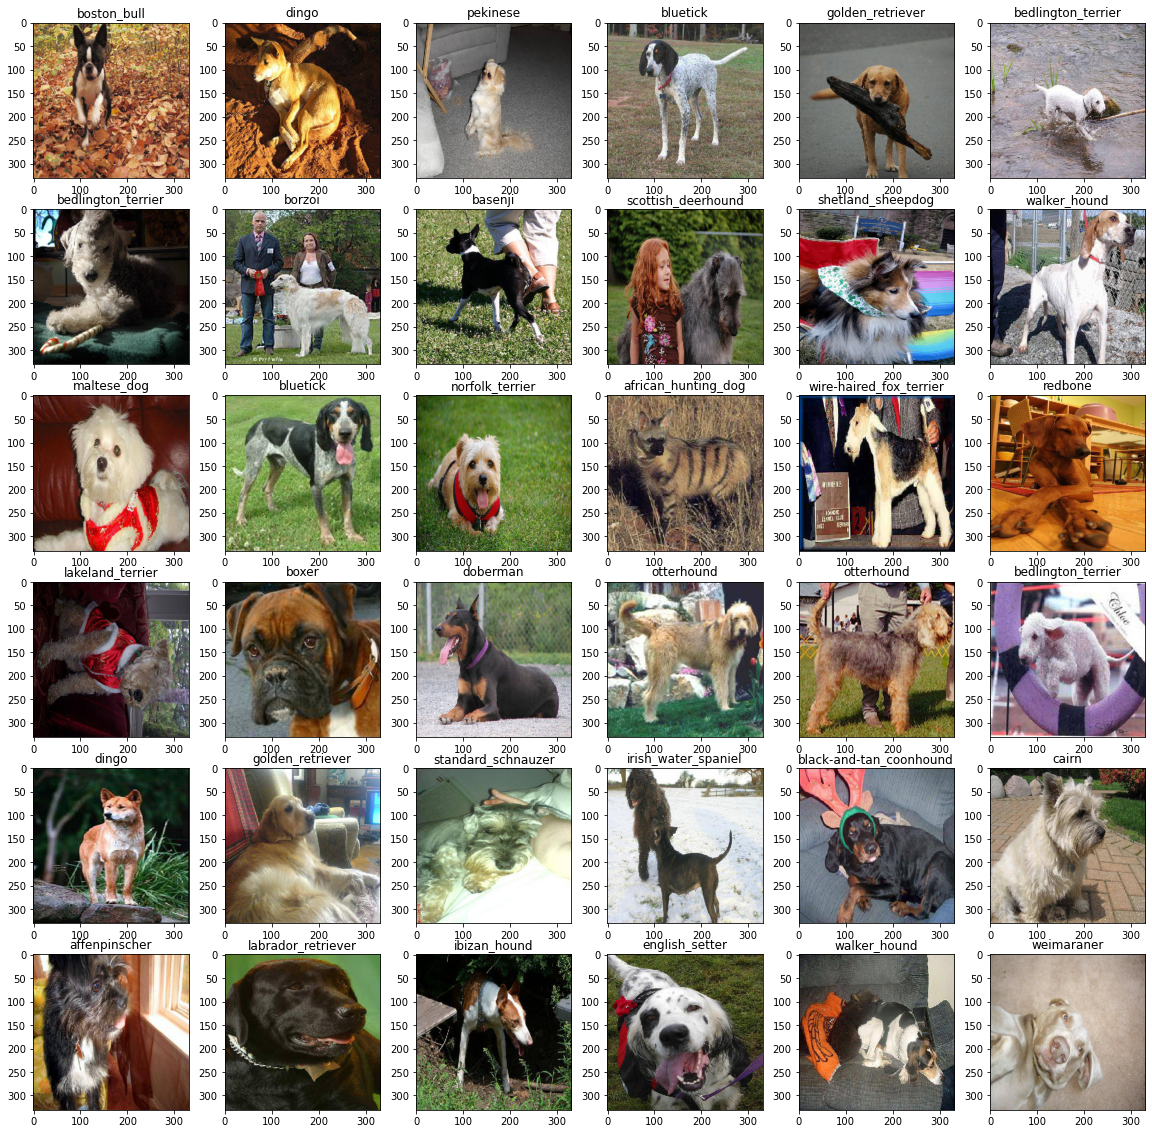

In [11]:
#check dog breeds
n=36

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(6, 6, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(x[i].astype('int32'))
           

In [12]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [14]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [15]:
# Extract features using InceptionV3 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, x)

320/320 [==============================] - 33s 88ms/step
Feature maps shape:  (10222, 2048)


In [16]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, x)

320/320 [==============================] - 50s 153ms/step
Feature maps shape:  (10222, 2048)


In [17]:
# Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, x)

320/320 [==============================] - 73s 216ms/step
Feature maps shape:  (10222, 1536)


In [18]:
# Extract features using NASNetLarge 
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, x)

320/320 [==============================] - 180s 544ms/step
Feature maps shape:  (10222, 4032)


In [19]:
del x #to free up some ram memory
gc.collect()

148486

In [20]:
#Creating final featuremap by combining all extracted features

final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 9664)


In [21]:
#Prepare Deep net

model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
64/64 [==============================] - 1s 14ms/step - loss: 2.1835 - accuracy: 0.5901 - val_loss: 0.1906 - val_accuracy: 0.9384
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1754 - accuracy: 0.9433 - val_loss: 0.1878 - val_accuracy: 0.9374
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1335 - accuracy: 0.9551 - val_loss: 0.1928 - val_accuracy: 0.9399
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1058 - accuracy: 0.9659 - val_loss: 0.1830 - val_accuracy: 0.9423
Epoch 5/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0920 - accuracy: 0.9671 - val_loss: 0.1890 - val_accuracy: 0.9438
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0740 - accuracy: 0.9769 - val_loss: 0.2032 - val_accuracy: 0.9384
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0630 - accuracy: 0.9783 - val_loss: 0.1883 - val_accuracy: 0.9403
Epoch 8/50
64/64 [=

In [22]:
#deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

1899

In [24]:
def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('../input/dog-breed-identification/test/', img_size)

  0%|          | 0/10357 [00:00<?, ?it/s]

Ouptut Data Size:  (10357, 331, 331, 3)


In [25]:
#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features

test_features = extact_features(test_data)

324/324 [==============================] - 30s 89ms/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 50s 153ms/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 182s 545ms/step
Feature maps shape:  (10357, 4032)
324/324 [==============================] - 73s 217ms/step
Feature maps shape:  (10357, 1536)
Final feature maps shape (10357, 9664)


In [26]:
#Free up some space.
del test_data
gc.collect()

20

In [27]:
#Predict test labels given test data features.

pred = model.predict(test_features)

In [30]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

[2.92770619e-06 2.57600527e-06 7.85537941e-06 4.18527861e-06
 6.67874217e-02 1.13168180e-05 4.63820070e-05 1.17521260e-04
 9.36784090e-07 9.40165046e-06 3.99181272e-06 4.61125268e-07
 4.78763752e-07 5.33348066e-06 2.26739076e-06 4.70341456e-06
 2.13871117e-05 3.78457116e-05 1.41300529e-06 4.08893757e-05
 3.21689913e-05 7.43426441e-04 1.66661812e-05 1.96530436e-06
 6.92625179e-07 4.63555625e-05 2.12156156e-05 1.91813779e-05
 1.18446414e-05 2.79976030e-06 1.67660583e-05 6.26711517e-06
 1.99163651e-06 4.57134865e-06 1.13627743e-06 7.22533696e-06
 5.81565155e-06 2.81097691e-05 3.32417312e-06 6.61801005e-06
 1.59443562e-06 3.60879608e-06 3.80488950e-06 9.93255526e-06
 1.40713814e-06 5.28016135e-05 1.67467442e-06 3.08903736e-06
 7.72109161e-07 6.73125487e-06 5.39127768e-06 3.67834150e-06
 4.67350674e-06 1.30989001e-05 3.76934008e-06 5.10907375e-06
 1.07691756e-06 1.07521855e-05 2.03664558e-06 9.57400698e-06
 1.02629201e-05 2.23575330e-06 3.90100467e-06 6.60990463e-06
 6.28907628e-06 8.778081

In [31]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [32]:
# Append test image ID's to predictions DataFrame
test_path = "../input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f7a32505c12649183c5991ecfa7d68b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bc6d50ffb4644feb34530aa58943e85b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7cbc041e79135a572aad87904b5c9c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f3b603f10d6a344f0395fb46b242ff8e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,2.92771e-06,2.57601e-06,7.85538e-06,4.18528e-06,0.0667874,1.13168e-05,4.6382e-05,0.000117521,9.36784e-07,...,9.18214e-06,0.000115024,2.71369e-06,4.18218e-06,6.72126e-07,1.06018e-06,1.26156e-05,5.95772e-05,1.77071e-05,1.16633e-05
1,f7a32505c12649183c5991ecfa7d68b3,1.64288e-07,2.70442e-07,2.05944e-07,9.56963e-07,3.35522e-07,5.33009e-07,3.70326e-07,2.11907e-06,3.54309e-06,...,8.55075e-07,7.22617e-07,2.08971e-05,7.07366e-06,3.49426e-07,2.26517e-07,7.4059e-08,1.51765e-07,7.99073e-08,2.51048e-07
2,bc6d50ffb4644feb34530aa58943e85b,1.62961e-06,0.000150735,2.48067e-05,1.48648e-05,1.65473e-06,1.14222e-05,5.31574e-06,2.91085e-06,2.7471e-06,...,8.24123e-06,2.01879e-06,1.67956e-06,1.37488e-05,1.76982e-06,2.64164e-06,2.23796e-07,7.63544e-06,8.32054e-07,1.00585e-06
3,7cbc041e79135a572aad87904b5c9c57,7.0267e-07,1.65061e-06,8.34719e-07,1.53787e-06,1.95268e-06,1.52053e-06,7.73424e-07,3.41523e-06,3.21188e-07,...,3.58342e-06,1.20079e-05,5.25243e-07,2.68963e-07,3.43677e-05,6.73682e-08,4.32663e-07,0.000178621,4.17428e-07,3.99695e-07
4,f3b603f10d6a344f0395fb46b242ff8e,8.20478e-07,4.10664e-06,8.47713e-06,6.89475e-06,7.68077e-07,8.71303e-06,5.9855e-06,9.01751e-06,5.08145e-05,...,6.72129e-06,2.35404e-06,6.40044e-07,6.77744e-06,1.18158e-06,0.998428,8.16907e-07,1.84628e-06,3.64969e-06,1.32815e-06


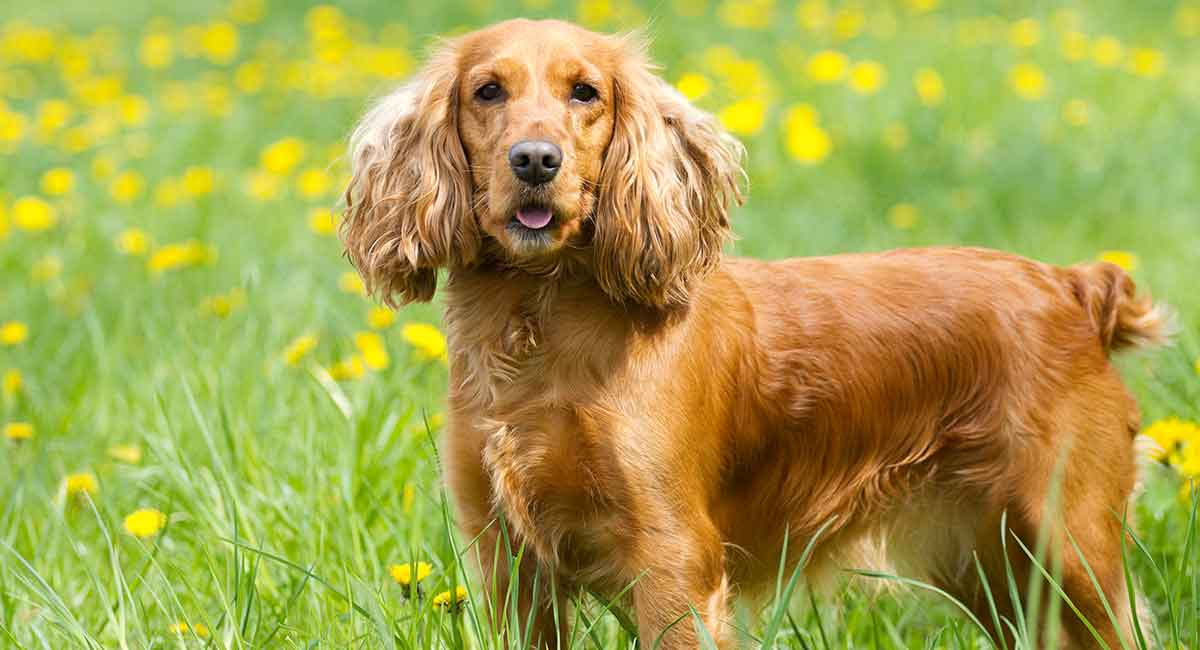

In [38]:
#Custom input

Image('../input/dogbreedidentification/The-English-Cocker-Spaniel-HP-long.jpg')

In [40]:
#reading the image and converting it into an np array

img_g = load_img('../input/dogbreedidentification/The-English-Cocker-Spaniel-HP-long.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0) # as we trained our model in (row, img_height, img_width, img_rgb) format, np.expand_dims convert the image into this format
# img_g

In [41]:
img_g.shape

(1, 331, 331, 3)

In [ ]:
#Predict test labels given test data features.
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")